In [10]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
from utils import get_idle_proportion

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('./system_analytics_2024/slurm_data')
folder_path_saving_results = Path('./results')


# read data from the cleaning note book
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_cleaned.parquet.gzip')
df.head(n=5)

,node,time,state
0,fcn1,2024-11-04 17:03:13,mixed
0,fcn1,2024-11-04 17:03:43,mixed
0,fcn1,2024-11-04 17:04:13,mixed
0,fcn1,2024-11-04 17:04:43,mixed
0,fcn1,2024-11-04 17:05:43,mixed


In [ ]:
""" 
Add some useful signals:
NO MISTAKE should happen here. 
"""

# add the node type and get the regular nodes only
df['node_type'] = df['node'].str[0:3]
df = df[df['node_type'].isin(['fcn', 'gcn', 'tcn', 'hcn'])].copy()

# put the time in an interval: if time is in [start-end], we add a tag as start
df['time_30min_interval'] = (df['time']).dt.floor(freq='30min')
df['time_1hour_interval'] = (df['time']).dt.floor(freq='1h')
df['time_2hour_interval'] = (df['time']).dt.floor(freq='2h')
df['time_3hour_interval'] = (df['time']).dt.floor(freq='3h')
df['time_6hour_interval'] = (df['time']).dt.floor(freq='6h')
df['time_12hour_interval'] = (df['time']).dt.floor(freq='12h')
df['time_day_interval'] = (df['time']).dt.floor(freq='d')


# # how long a state last?
# df['duration'] = df.groupby('node')['time'].diff(1).shift(-1)
# # drop the rows that beccome Nan due to shift
# df = df[~(df['duration'].isna())]

# display a sample
N = len(df)//10
display(df.iloc[N: N + 5, :])


# save the data for the machine learning norte book.
# df.to_parquet(folder_path_slurm_data/'sinfo_EDA_cleaned.parquet.gzip', compression='gzip')

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval
30,gcn127,2024-11-14 12:41:21,allocated,gcn,2024-11-14 12:30:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14
31,gcn127,2024-11-14 12:42:20,allocated,gcn,2024-11-14 12:30:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14
31,gcn127,2024-11-14 12:43:21,allocated,gcn,2024-11-14 12:30:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14
31,gcn127,2024-11-14 12:45:21,allocated,gcn,2024-11-14 12:30:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14
31,gcn127,2024-11-14 12:46:21,allocated,gcn,2024-11-14 12:30:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14 12:00:00,2024-11-14


In [13]:
""" 
Pick a time interval to do the rest of the analysis
later we put all the codes in a function so we can always change the time_col
easily
NO MISTAKE SHOULD HAPPEN HERE. 
"""
time_col = 'time_6hour_interval' # from here until the moment we get the dataframe for plotting, put it in a function
# take a copy
df_with_duration = df.copy()
# how long does a state last? we are ignoreing those samples outside of the time interval. Does this make sense? Do I do it correclty?
df_with_duration['state_duration'] = df_with_duration.groupby(['node', time_col])['time'].diff(1).shift(-1)
# drop the rows that beccome Nan due to shift
df_with_duration = df_with_duration[~(df_with_duration['state_duration'].isna())]
# show me a sample and tell me as a sanity check what is the maximum duration? It should be lower than time interval
N = len(df_with_duration)//10
display(df_with_duration.iloc[N: N + 6, :], df_with_duration['state_duration'].describe(percentiles=[0.999]))
"""  
Here we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.
But 99.9 percent of the states takes around 5 minutes.
"""

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval,state_duration
9,gcn127,2024-11-14 09:48:05,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:00
9,gcn127,2024-11-14 09:49:05,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:00
9,gcn127,2024-11-14 09:50:05,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:00
9,gcn127,2024-11-14 09:51:05,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:00
9,gcn127,2024-11-14 09:52:05,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:01
9,gcn127,2024-11-14 09:53:06,idle,gcn,2024-11-14 09:30:00,2024-11-14 09:00:00,2024-11-14 08:00:00,2024-11-14 09:00:00,2024-11-14 06:00:00,2024-11-14,2024-11-14,0 days 00:01:00


count                     33924636
mean     0 days 00:00:49.122869291
std      0 days 00:00:46.804355557
min                0 days 00:00:01
50%                0 days 00:00:31
99.9%              0 days 00:05:05
max                0 days 01:30:47
Name: state_duration, dtype: object

'  \nHere we see the bad samples that we had in the clening notebook. Some of the states (they are rare) takes 1.5 hour.\nBut 99.9 percent of the states takes around 5 minutes.\n'

In [14]:
"""  
No mistake should happen here.
"""
# compute the total time a node was in a state in a given inteval
df_temp = df_with_duration.groupby(['node', time_col, 'state' ], as_index=False)[['state_duration']].sum()
df_temp.sort_values(['node', time_col], inplace=True)
df_temp.rename(columns={'state_duration':'state_duration_in_interval'}, inplace=True)

# show a smaple
N = len(df_temp)//10
display(df_temp.iloc[N: N + 10, :], "The maximum duration for a node in a state is:",df_temp['state_duration_in_interval'].max())
# note it is ok to get maximum duration smaller than the time interval
# we can change this behavior by doing the diff the way we did in the previous cell

,node,time_6hour_interval,state,state_duration_in_interval
13312,gcn144,2024-11-06 12:00:00,completing,0 days 00:02:00
13313,gcn144,2024-11-06 12:00:00,draining,0 days 00:00:30
13314,gcn144,2024-11-06 12:00:00,mixed,0 days 02:44:57
13315,gcn144,2024-11-06 18:00:00,allocated,0 days 00:42:05
13316,gcn144,2024-11-06 18:00:00,completing,0 days 00:00:30
13317,gcn144,2024-11-06 18:00:00,mixed,0 days 05:16:39
13318,gcn144,2024-11-07 00:00:00,mixed,0 days 05:58:51
13319,gcn144,2024-11-07 06:00:00,allocated,0 days 00:27:03
13320,gcn144,2024-11-07 06:00:00,completing,0 days 00:01:00
13321,gcn144,2024-11-07 06:00:00,idle,0 days 00:43:38


'The maximum duration for a node in a state is:'

Timedelta('0 days 05:59:53')

In [15]:

"""  
No mistake here as well, crucial for later usages.
"""

# get the total time for all the states
df_total = df_temp.groupby(['node', time_col], as_index=False)['state_duration_in_interval'].sum().copy()
df_total.rename(columns={'state_duration_in_interval':'all_state_durations_in_interval'}, inplace=True)

# get the idle time for the states
df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'state_duration_in_interval':'idle_duration'}, inplace=True)

# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_total, how='outer', on=['node', time_col])
df_stat.fillna(value=pd.Timedelta('0s'), inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)

# divide the total idle duration in the interval by the total time of all the states: 
# we get proportion of the time that idle happened in the interval
df_stat['idle_proportion'] = (df_stat['idle_duration'] / df_stat['all_state_durations_in_interval'])


# show the data frame that we have
display(df_total.head(), df_idle.head(), df_stat.head())




,node,time_6hour_interval,all_state_durations_in_interval
0,fcn1,2024-11-04 12:00:00,0 days 00:56:38
1,fcn1,2024-11-04 18:00:00,0 days 05:58:52
2,fcn1,2024-11-05 00:00:00,0 days 05:59:32
3,fcn1,2024-11-05 06:00:00,0 days 05:58:47
4,fcn1,2024-11-05 12:00:00,0 days 05:59:12


,node,time_6hour_interval,idle_duration
26,fcn1,2024-11-09 06:00:00,0 days 02:59:30
28,fcn1,2024-11-09 12:00:00,0 days 05:59:29
29,fcn1,2024-11-09 18:00:00,0 days 05:59:10
30,fcn1,2024-11-10 00:00:00,0 days 05:59:20
31,fcn1,2024-11-10 06:00:00,0 days 05:59:12


,node,time_6hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
0,fcn1,2024-11-04 12:00:00,0 days,0 days 00:56:38,0.0
1,fcn1,2024-11-04 18:00:00,0 days,0 days 05:58:52,0.0
2,fcn1,2024-11-05 00:00:00,0 days,0 days 05:59:32,0.0
3,fcn1,2024-11-05 06:00:00,0 days,0 days 05:58:47,0.0
4,fcn1,2024-11-05 12:00:00,0 days,0 days 05:59:12,0.0


In [16]:

# pick a time col again, the function does the same thing as above for a specifc interval
time_col = 'time_12hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
display(df_total.head(), df_idle.head(), df_stat.head())



# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
display(df_stat_pivot.head())

,node,time_12hour_interval,all_state_durations_in_interval
0,fcn1,2024-11-04 12:00:00,0 days 06:56:30
1,fcn1,2024-11-05 00:00:00,0 days 11:59:20
2,fcn1,2024-11-05 12:00:00,0 days 11:59:55
3,fcn1,2024-11-06 00:00:00,0 days 11:58:48
4,fcn1,2024-11-06 12:00:00,0 days 11:59:39


,node,time_12hour_interval,idle_duration
13,fcn1,2024-11-09 00:00:00,0 days 02:59:30
15,fcn1,2024-11-09 12:00:00,0 days 11:59:40
16,fcn1,2024-11-10 00:00:00,0 days 11:59:03
18,fcn1,2024-11-10 12:00:00,0 days 09:22:06
23,fcn1,2024-11-11 12:00:00,0 days 01:13:04


,node,time_12hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
0,fcn1,2024-11-04 12:00:00,0 days,0 days 06:56:30,0.0
1,fcn1,2024-11-05 00:00:00,0 days,0 days 11:59:20,0.0
2,fcn1,2024-11-05 12:00:00,0 days,0 days 11:59:55,0.0
3,fcn1,2024-11-06 00:00:00,0 days,0 days 11:58:48,0.0
4,fcn1,2024-11-06 12:00:00,0 days,0 days 11:59:39,0.0


node                  fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_12hour_interval                                                         
2024-11-04 12:00       0.0  0.0241     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00       0.0  0.7237     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00       0.0  0.3128     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00       0.0  0.6942     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00       0.0  0.6301     1.0     1.0     1.0     1.0     1.0   

node                  fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0  0.0000     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0  0.4474     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0  0.3567     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0  0.8704     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0  0.7890     1.0   

node                  fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-05 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 00:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2024-11-06 12:00         1.0     1.0     1.0     1.0     1.0     1.0     1.0   

node                  fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_12hour_interval                                                           
2024-11-04 12:00         1.0     1.0  0.0241     1.0  0.0241  0.0000  0.0241   
2024-11-05 00:00         1.0     1.0  0.2756     1.0  0.7029  0.0000  0.7202   
2024-11-05 12:00         1.0     1.0  0.6519     1.0  0.2434  0.0000  0.7178   
2024-11-06 00:00         1.0     1.0  0.6669     1.0  0.8746  0.0293  0.8815   
2024-11-06 12:00         1.0     1.0  0.0000     1.0  0.4929  0.7785  0.2843   

node                   fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0241  0.0241  0.9938  0.0000  0.0241  0.0241   
2024-11-05 00:00      0.7644  0.7188  0.7323  1.0000  0.0000  0.7323  0.7323   
2024-11-05 12:00      0.0900  0.0914  0.9094  1.0000  0.0000  0.9115  0.9115   
2024-11-06 00:00      0.1874  0.1972  0.9610  1.0000  0.1596  0.9610  0.9749   
2024-11-06 12:00      0.8572  0.8544  0.8544  0.9958  0.0000  0.8551  0.8182   

node                   fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0241  0.0241  0.0241  0.9938  0.0241  0.0241  0.0241   
2024-11-05 00:00      0.7323  0.7323  0.7323  1.0000  0.0000  0.4111  0.7323   
2024-11-05 12:00      0.7265  0.9638  1.0000  1.0000  0.8967  1.0000  1.0000   
2024-11-06 00:00      0.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.0000  0.8175  0.8175  0.9958  0.8224  0.8210  0.8468   

node                   fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_12hour_interval                                                           
2024-11-04 12:00      0.0253  0.0000  0.0241  0.0241  0.0240  0.0241  0.0241   
2024-11-05 00:00      0.0000  0.0000  0.7323  0.6355  0.4441  0.3057  0.7323   
2024-11-05 12:00      0.9045  0.0327  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 00:00      1.0000  0.6003  1.0000  1.0000  1.0000  1.0000  1.0000   
2024-11-06 12:00      0.8495  0.5772  0.8642  0.8537  0.8356  0.8245  0.8140   

node                   fcn35   fcn36   fcn37   fcn38   fcn39  fcn4   fcn40  \
time_12ho

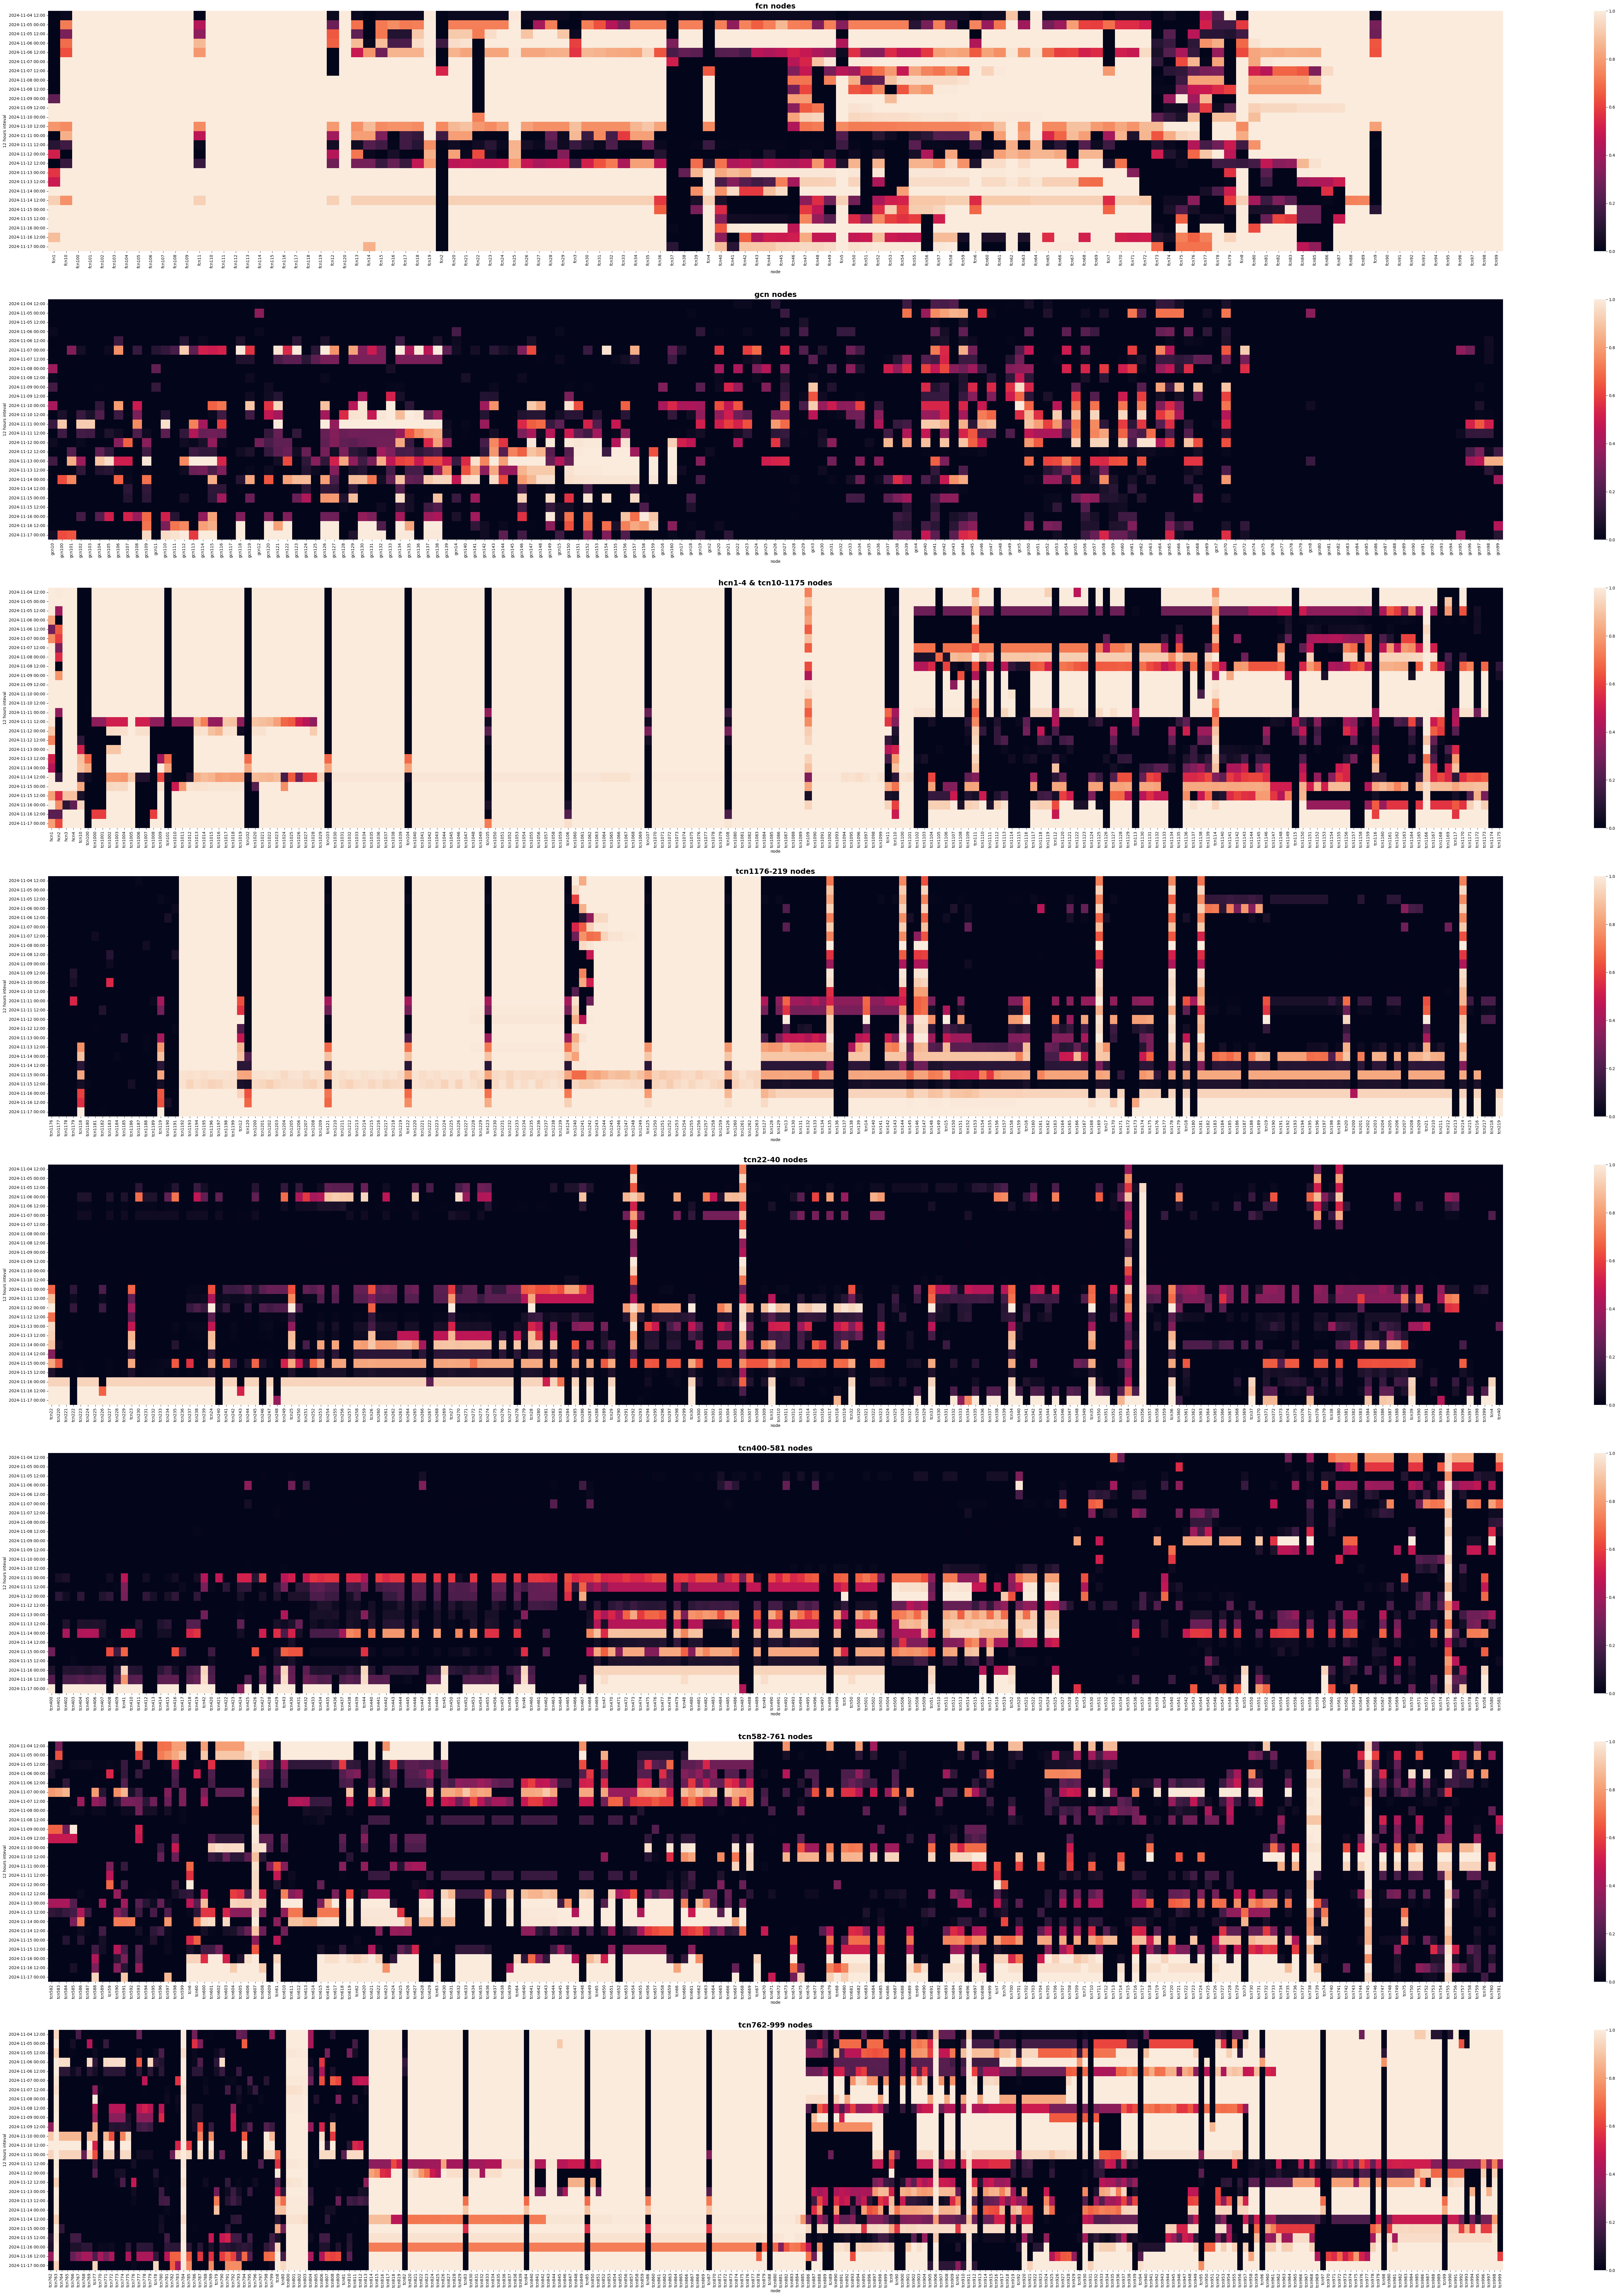

In [17]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 100))
# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]
titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]



map_time_column_names = {"time_30min_interval": "30 minutes interval",
                         "time_1hour_interval": "1 hour interval",
                         "time_3hour_interval": "3 hours interval",
                         "time_6hour_interval": "6 hours interval",
                         "time_12hour_interval": "12 hours inteval",
                         "time_day_interval": "1 day interval"
                             }


# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_stat_pivot.iloc[:, start:end], ax=ax[i], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot
    ax[i].set_ylabel(map_time_column_names[time_col])

fig.savefig(folder_path_saving_results/f"nodes_idle_partition_{time_col}.pdf", transparent=True)
fig.savefig(folder_path_saving_results/f"nodes_idle_partition_{time_col}.png", dpi=200)
plt.show()

# move the figures to the laptop for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .

In [18]:
"""  
sort the data form high to low occupied nodes
"""
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()
df_sorted_nodes.head()

node                  tcn179  tcn423  gcn83  gcn84  gcn88  gcn87  gcn94  \
time_12hour_interval                                                      
2024-11-04 12:00         0.0     0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00         0.0     0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00         0.0     0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00         0.0     0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00         0.0     0.0    0.0    0.0    0.0    0.0    0.0   

node                  gcn93  gcn92  gcn91  gcn90  gcn89  gcn86  gcn85  \
time_12hour_interval                                                    
2024-11-04 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0    0.0    0.0    0.0    0.0    0.0   

node                  tcn1176  tcn1174  gcn82  gcn4  gcn80  gcn74  gcn78  \
time_12hour_interval                                                       
2024-11-04 12:00          0.0      0.0    0.0   0.0    0.0    0.0    0.0   
2024-11-05 00:00          0.0      0.0    0.0   0.0    0.0    0.0    0.0   
2024-11-05 12:00          0.0      0.0    0.0   0.0    0.0    0.0    0.0   
2024-11-06 00:00          0.0      0.0    0.0   0.0    0.0    0.0    0.0   
2024-11-06 12:00          0.0      0.0    0.0   0.0    0.0    0.0    0.0   

node                  gcn77  gcn76  tcn346  tcn1177  gcn81  gcn75  gcn79  \
time_12hour_interval                                                       
2024-11-04 12:00        0.0    0.0     0.0      0.0    0.0    0.0    0.0   
2024-11-05 00:00        0.0    0.0     0.0      0.0    0.0    0.0    0.0   
2024-11-05 12:00        0.0    0.0     0.0      0.0    0.0    0.0    0.0   
2024-11-06 00:00        0.0    0.0     0.0      0.0    0.0    0.0    0.0   
2024-11-06 12:00        0.0    0.0     0.0      0.0    0.0    0.0    0.0   

node                  tcn288  tcn535  tcn703  tcn702  gcn117  tcn464  tcn290  \
time_12hour_interval                                                           
2024-11-04 12:00         0.0     0.0     0.0     0.0  0.0000     0.0  0.0000   
2024-11-05 00:00         0.0     0.0     0.0     0.0  0.0000     0.0  0.0007   
2024-11-05 12:00         0.0     0.0     0.0     0.0  0.0007     0.0  0.0000   
2024-11-06 00:00         0.0     0.0     0.0     0.0  0.0000     0.0  0.0000   
2024-11-06 12:00         0.0     0.0     0.0     0.0  0.0000     0.0  0.0000   

node                  tcn740  tcn741  tcn737  tcn1178  gcn71  tcn523  tcn510  \
time_12hour_interval                                                           
2024-11-04 12:00         0.0     0.0     0.0      0.0    0.0     0.0     0.0   
2024-11-05 00:00         0.0     0.0     0.0      0.0    0.0     0.0     0.0   
2024-11-05 12:00         0.0     0.0     0.0      0.0    0.0     0.0     0.0   
2024-11-06 00:00         0.0     0.0     0.0      0.0    0.0     0.0     0.0   
2024-11-06 12:00         0.0     0.0     0.0      0.0    0.0     0.0     0.0   

node                  tcn321  gcn48  tcn559  tcn557  tcn672  tcn172  tcn213  \
time_12hour_interval                                                          
2024-11-04 12:00         0.0    0.0     0.0     0.0     0.0  0.0024     0.0   
2024-11-05 00:00         0.0    0.0     0.0     0.0     0.0  0.0000     0.0   
2024-11-05 12:00         0.0    0.0     0.0     0.0     0.0  0.0007     0.0   
2024-11-06 00:00         0.0    0.0     0.0     0.0     0.0  0.0000     0.0   
2024-11-06 12:00         0.0    0.0     0.0     0.0     0.0  0.0000     0.0   

node                  tcn428  tcn88  tcn1184  tcn1187  tcn498  tcn1180  \
time_12hour_interval                                                     
2024-11-04 12:00         0.0    0.0   0.0000   0.0228  0.0000      0.0  

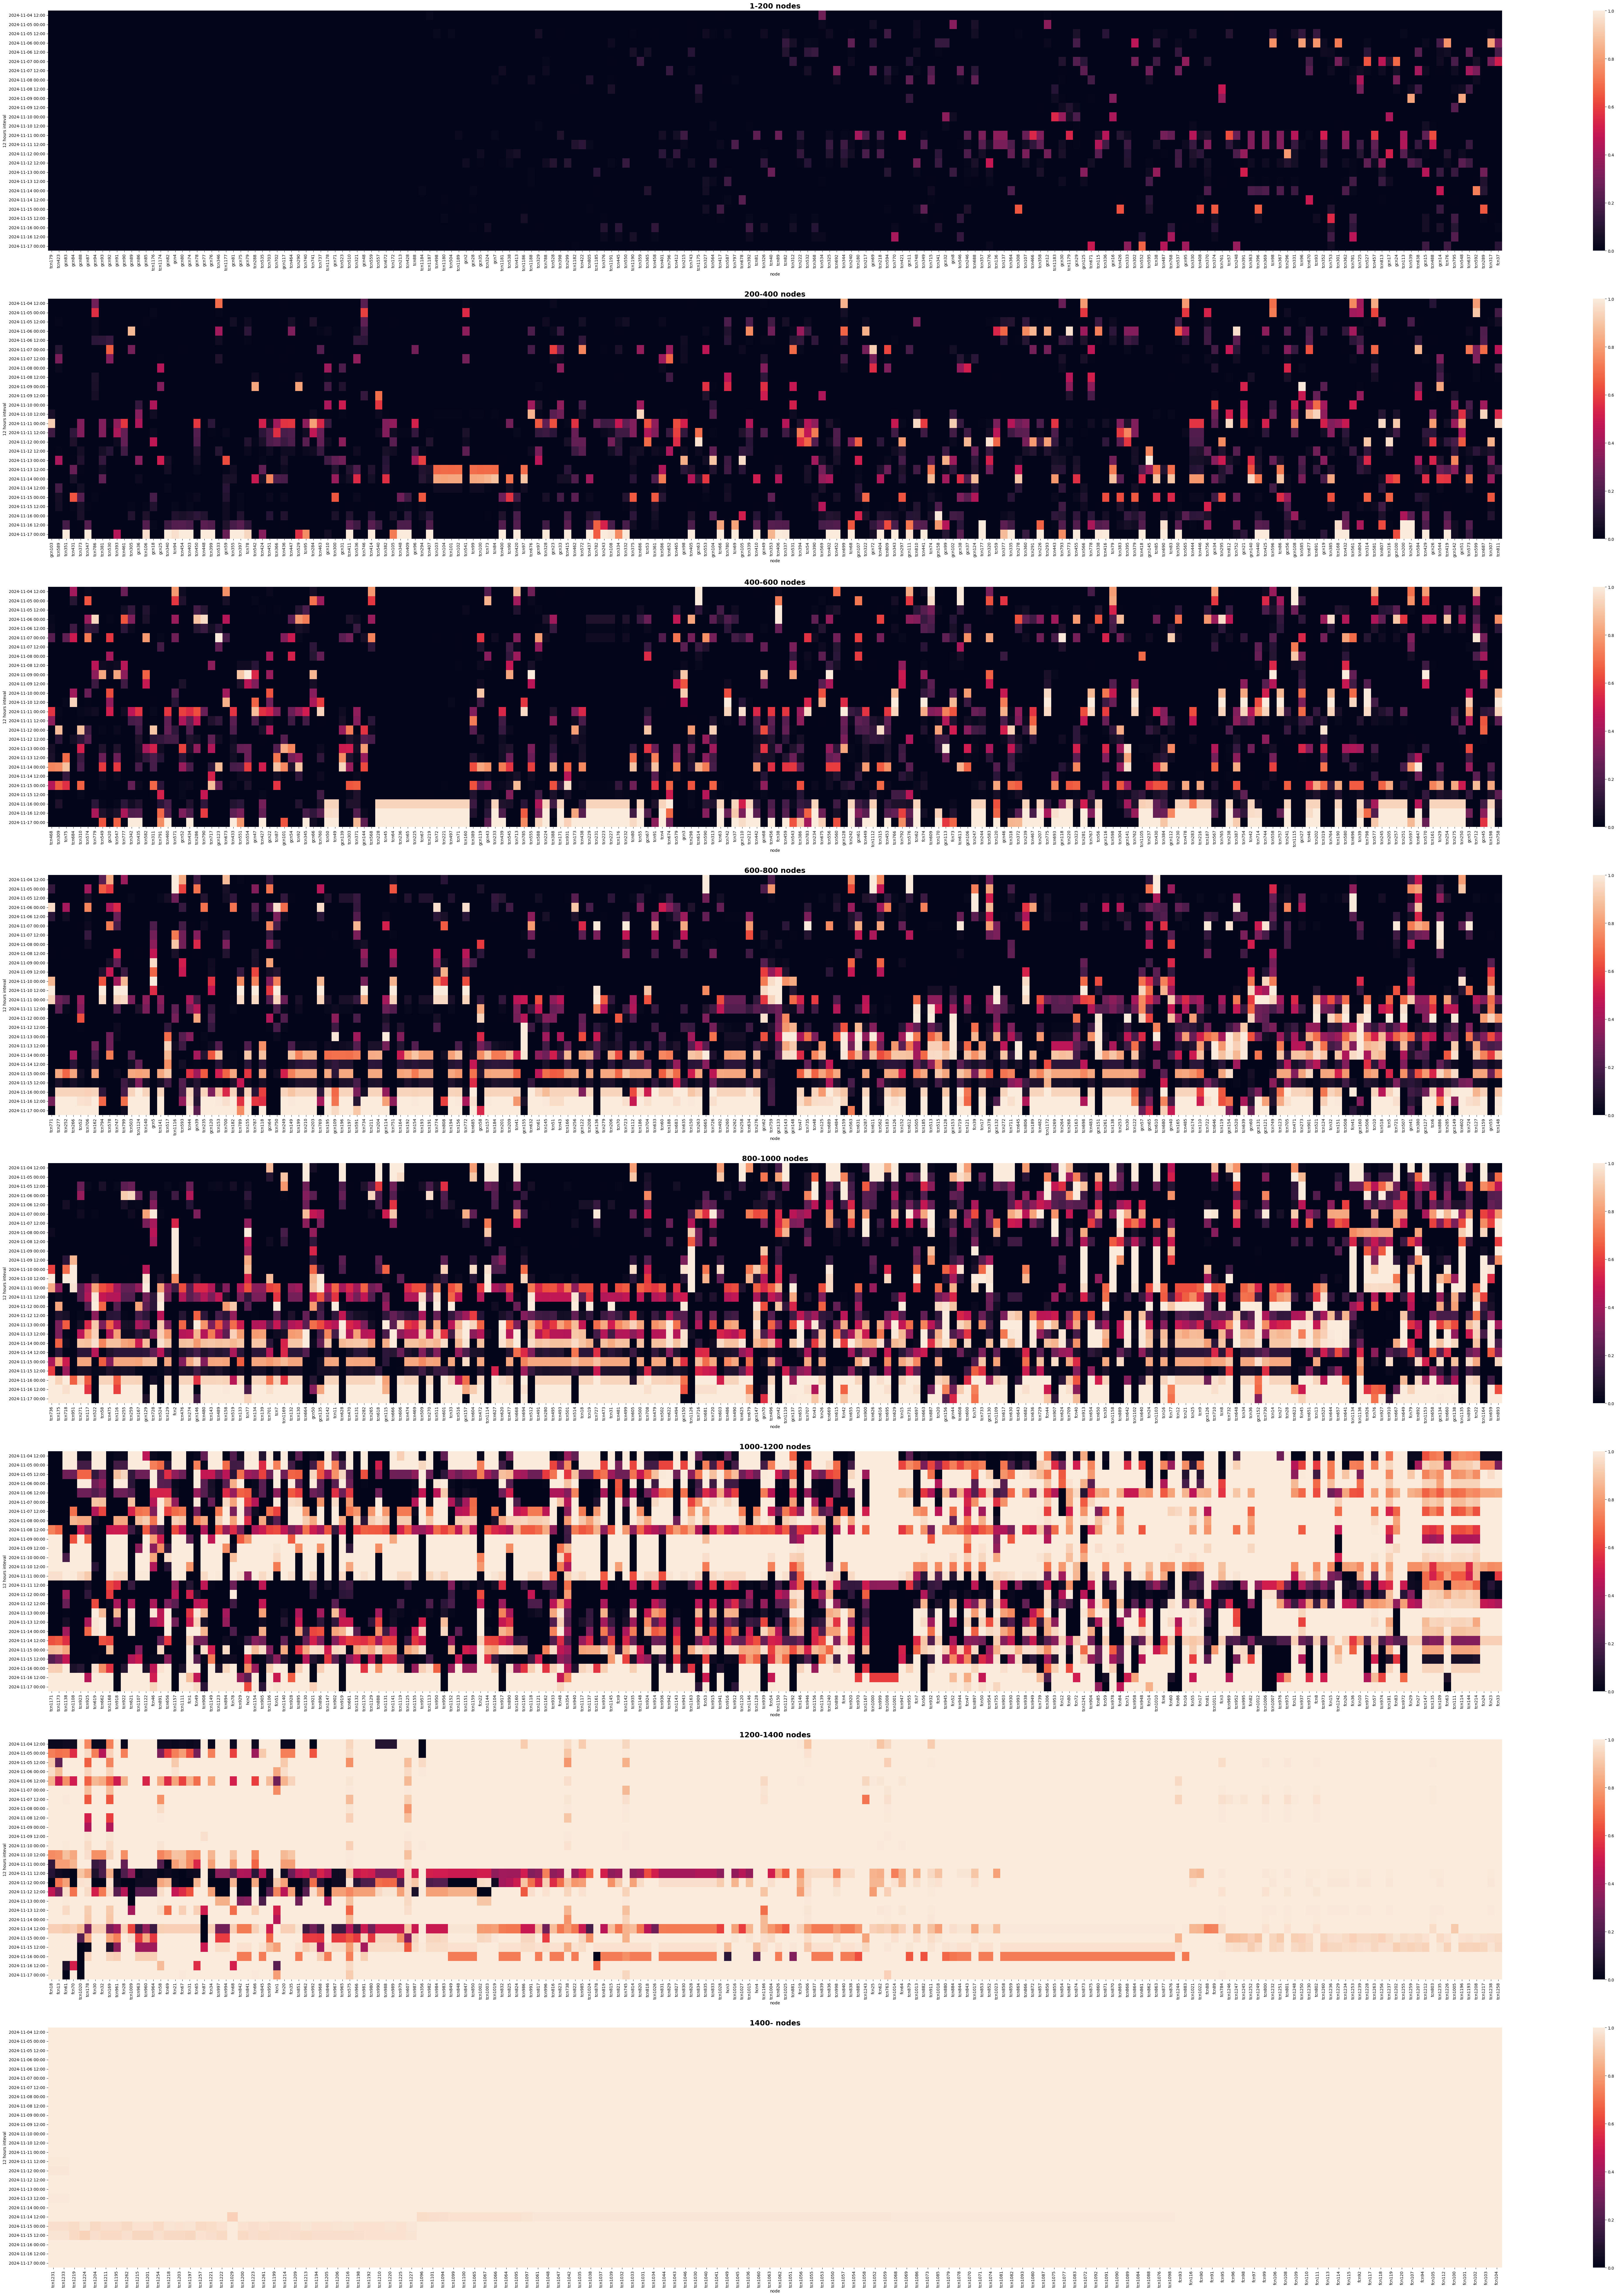

In [19]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 100))
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_sorted_nodes.iloc[:, start:end], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                ax=ax[i], cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18, fontweight="bold")  # Set title for each subplot
    ax[i].set_ylabel(map_time_column_names[time_col])
    # Set x and y tick parameters to bold font
    # ax[i].tick_params(axis='x', labelsize=12)  # Bold x-tick labels
    # ax[i].tick_params(axis='y', labelsize=12)   # Bold y-tick labels

    # ax[i].xaxis.set_tick_params(labelsize=12)
    # ax[i].yaxis.set_tick_params(labelsize=12)
fig.savefig(folder_path_saving_results/f"nodes_idle_ranked_{time_col}.pdf", transparent=True)
fig.savefig(folder_path_saving_results/f"nodes_idle_ranked_{time_col}.png", dpi=200)
plt.show()

In [28]:
"""  
DO WE HAVE MISSING VALUES? It is important to see if there is any missing value in our measurements.
We have to look at start and end time for all series.
Do they have the same length? Do they have the same frequency?
It seems that for larger time interval all the series have the same lenght, but for interval 
less than and equal to 2 hours some series have missing values. ==>> WHAT are these nodes? see next cell
"""
# select different time_interval: If we use the data with 1 hour inteval do we get any missing values?
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# find the min and max time and the number of samples for each node
df_stat_min_time_max_time = df_stat.groupby('node', as_index=False)[time_col].agg(['min', 'max', 'count'])
# find the measurement frequency for each node. Is it the same with time col?
df_stat_freq = df_stat.groupby('node')[time_col].diff(1).value_counts()
display(df_stat_min_time_max_time.sample(n=10), df_stat_min_time_max_time.describe(), df_stat_freq)

,node,min,max,count
1364,tcn842,2024-11-04 17:00:00,2024-11-17 07:00:00,302
748,tcn286,2024-11-04 17:00:00,2024-11-17 07:00:00,303
891,tcn415,2024-11-04 17:00:00,2024-11-17 07:00:00,303
943,tcn462,2024-11-04 17:00:00,2024-11-17 07:00:00,303
1032,tcn543,2024-11-04 17:00:00,2024-11-17 07:00:00,303
1300,tcn785,2024-11-04 17:00:00,2024-11-17 07:00:00,303
1102,tcn606,2024-11-04 17:00:00,2024-11-17 07:00:00,303
77,fcn60,2024-11-04 17:00:00,2024-11-17 07:00:00,302
491,tcn1190,2024-11-04 17:00:00,2024-11-17 07:00:00,303
708,tcn25,2024-11-04 17:00:00,2024-11-17 07:00:00,303


,min,max,count
count,1538,1538,1538.0000
mean,2024-11-04 17:00:00,2024-11-17 07:00:00,302.6456
min,2024-11-04 17:00:00,2024-11-17 07:00:00,302.0000
25%,2024-11-04 17:00:00,2024-11-17 07:00:00,302.0000
50%,2024-11-04 17:00:00,2024-11-17 07:00:00,303.0000
75%,2024-11-04 17:00:00,2024-11-17 07:00:00,303.0000
max,2024-11-04 17:00:00,2024-11-17 07:00:00,303.0000
std,NaN,NaN,0.4785


time_1hour_interval
0 days 01:00:00    463386
0 days 02:00:00       545
Name: count, dtype: int64

'  \nIt is very confusing why not all the nodes have missing values? Does this mean that the missing value\nis because of the fact that these nodes did not appear in sinfo or it was measurement error?\n'

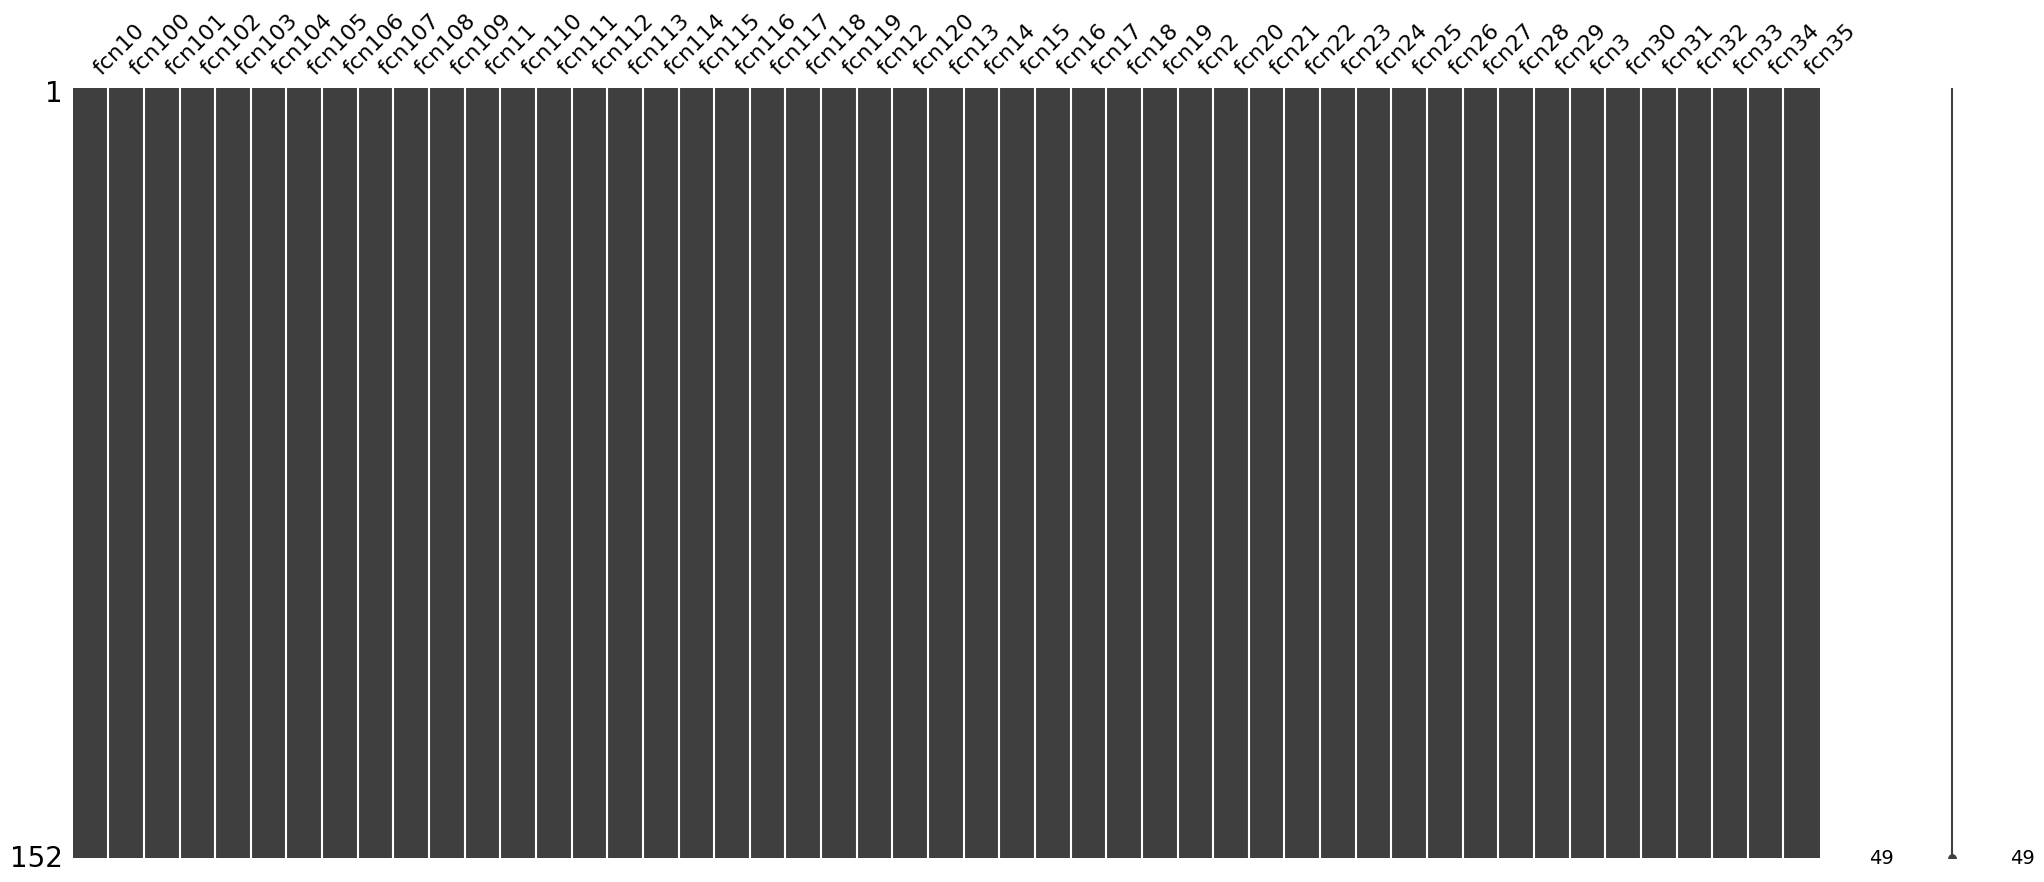

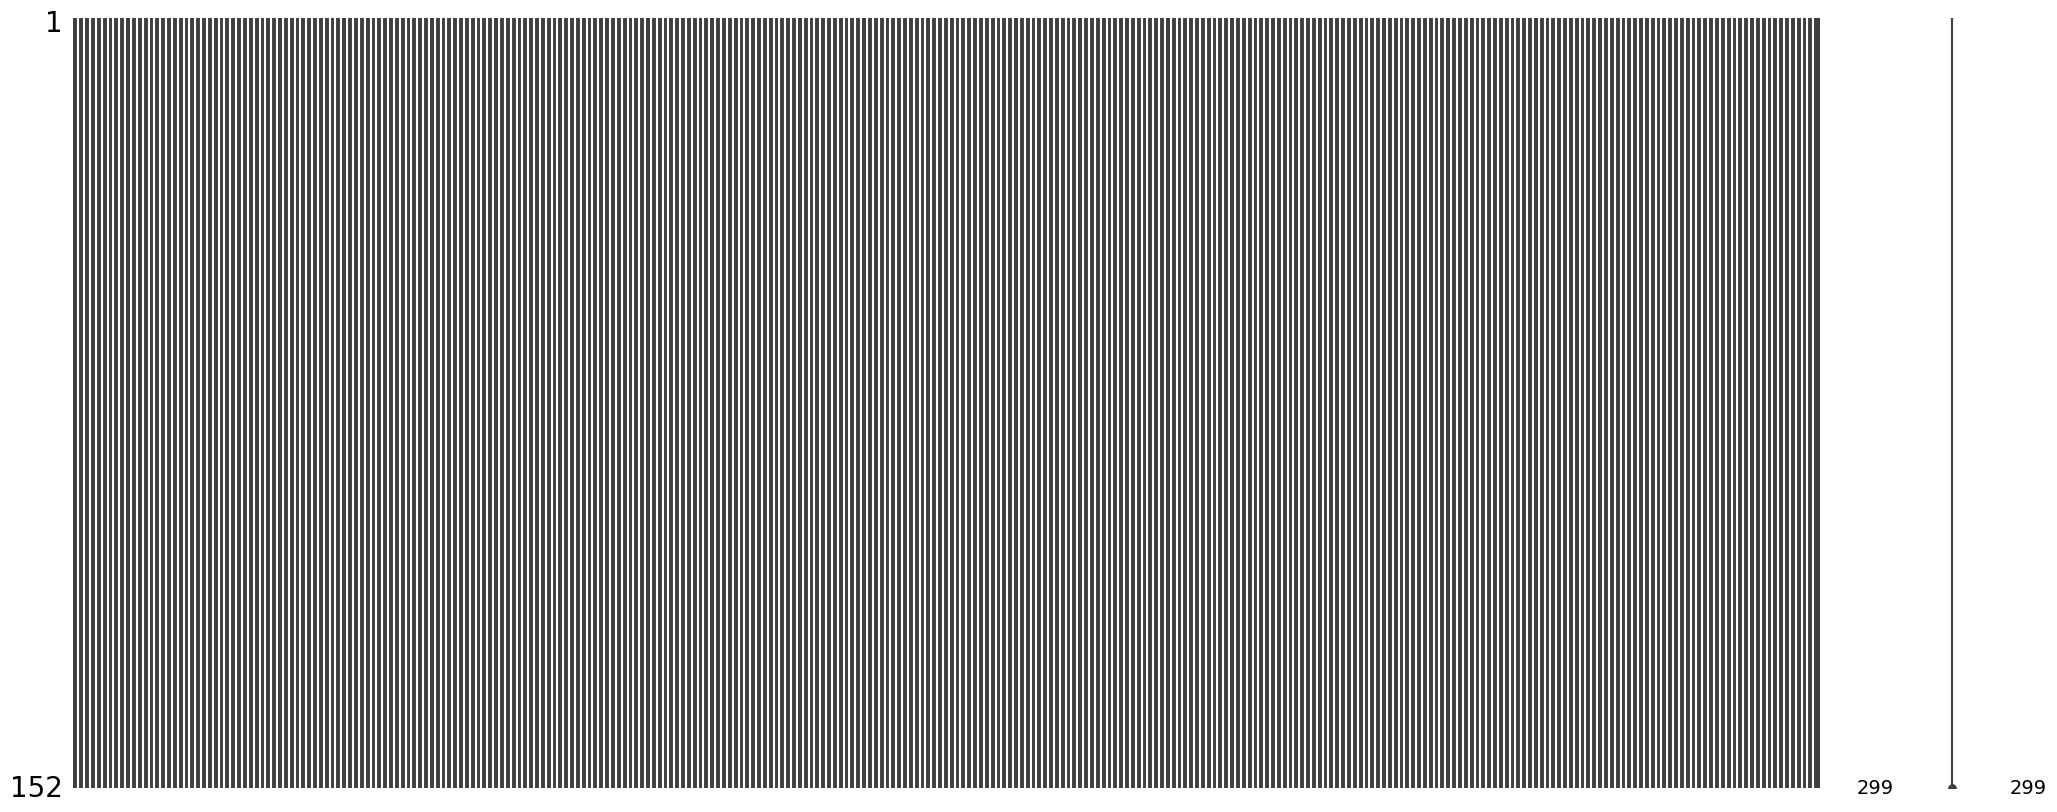

In [26]:
"""  
Show the some of the ndoes that have missing values
show the all the nodes that have missing values
The white spaces show the sample that is missing in the data for a  specific node.
"""
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")

node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_stat_pivot.iloc[:,1:50])
msno.matrix(df_sorted_nodes.iloc[:, 1:300])

"""  
It is very confusing why not all the nodes have missing values? Does this mean that the missing value
is because of the fact that these nodes did not appear in sinfo or it was measurement error?
"""